In [111]:

import numpy as np 

naca = np.loadtxt('naca0012.csv', skiprows=9, delimiter=',')[::3,:]/100.




In [112]:
import pygmsh

with pygmsh.occ.Geometry() as geom:
    outer = geom.add_disk([0.0, 0.0], 5.0, mesh_size=1.0)
    inner = geom.add_polygon(naca, mesh_size=0.1,
    )
    geom.boolean_difference(outer, inner)
    mesh = geom.generate_mesh()


nodes = mesh.points
alpha = 10.*np.pi/180.
nodes[:,0], nodes[:,1] = nodes[:,0]*np.cos(alpha) + nodes[:,1]*np.sin(alpha), nodes[:,1]*np.cos(alpha) - nodes[:,0]*np.sin(alpha)
elems = mesh.cells_dict['triangle']

/home/jakob/.local/lib/python3.8/site-packages/pygmsh/occ/geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 1> discarded in Boolean difference operation.
  warnings.warn(


<meshio mesh object>
  Number of points: 382
  Number of cells:
    line: 67
    triangle: 697
    vertex: 45

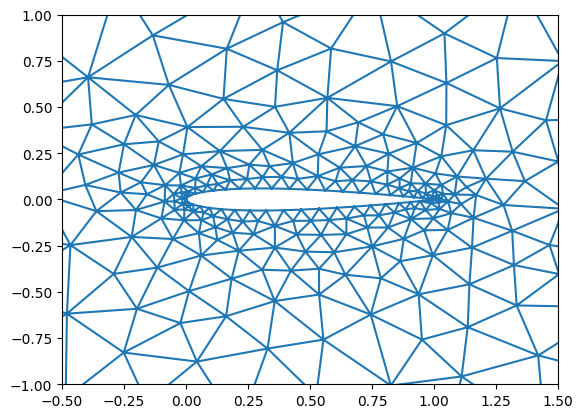

In [113]:
from matplotlib import pyplot as plt 

plt.figure() 
plt.triplot(nodes[:,0], nodes[:,1], elems)
_ = plt.axis([-0.5, 1.5, -1., 1.])

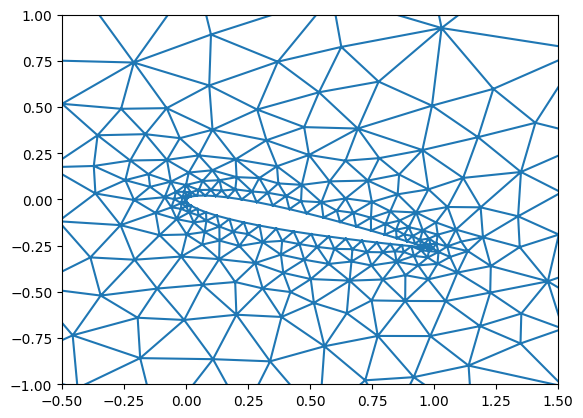

In [119]:
# nodes = np.array([[0., 0.],
#                   [1., 0.],
#                   [1., 1.], 
#                   [3., 1.]])

# elems = np.array([[0, 1, 2], 
#                   [2, 1, 3]])

# CONNECTIVITY
n_elems = elems.shape[0]
sides = np.concatenate((elems[:,:2], elems[:,1:], elems[:,::-2]))

sides, uniquesideids, elem2side_flat = np.unique(np.sort(sides), axis=0, return_index=True, return_inverse=True)
n_sides = sides.shape[0]
elem2side = np.transpose(np.reshape(elem2side_flat, (3, n_elems)))

# build side2elem
elem_ind = np.mod(np.arange(3*n_elems), n_elems)
sideid_2_elemid = np.transpose(np.stack((elem2side_flat, elem_ind)))
side2elem = np.zeros((n_sides, 2)).astype(int)-1
side2elem[sideid_2_elemid[uniquesideids,0],0] = sideid_2_elemid[uniquesideids,1]
sideid_2_elemid = np.delete(sideid_2_elemid, uniquesideids, axis=0)
side2elem[sideid_2_elemid[:,0],1] = sideid_2_elemid[:,1]

bcsides = np.argwhere(side2elem[:,1]<0)[:,0]
bc_wall = bcsides[np.linalg.norm(nodes[sides[bcsides,0],:], axis=1)<2.]
bc_outr = bcsides[np.linalg.norm(nodes[sides[bcsides,0],:], axis=1)>2.] 

In [115]:
# metrics 
volume = np.abs(np.cross(nodes[elems[:,1],:]-nodes[elems[:,0],:], nodes[elems[:,2],:]-nodes[elems[:,0],:], axis=1))/2.
diff = nodes[sides[:,1],:] - nodes[sides[:,0],:]
length = np.linalg.norm(diff, axis=1)
normal = np.stack((diff[:,1]/length , -diff[:,0]/length), axis = 1) 
# nodes are ccw in elems array
outward_factor=np.zeros_like(elem2side)
for iside in range(3):
    fstnodeloc = np.argwhere(np.equal(elems, sides[elem2side[:,iside],:1]))[:,1]
    sndnodeloc = np.argwhere(np.equal(elems, sides[elem2side[:,iside],1:]))[:,1]
    outward_factor[:,iside] = np.where(np.equal(np.mod(sndnodeloc-fstnodeloc, 3), 1), 1, -1)

In [120]:
# initialize
DENS = 0
MOMX = 1
MOMY = 2 
MOMV = [MOMX, MOMY]
ENER = 3

freeflow = np.zeros((1,4))
freeflow[:,DENS] = 1.
freeflow[:,MOMX] = 1.
freeflow[:,MOMY] = 0.
freeflow[:,ENER] = 2. 

u = np.zeros((n_elems, 4))
u = freeflow

u_left = np.zeros((n_sides, 4))
u_right = np.zeros((n_sides, 4))

u_right[bc_outr,:] = freeflow

In [ ]:
# fill sides
u_left[:,:] = u[elem2side[:,0],:]
u_right[:,:] = u[elem2side[:,1],:]

# fill BC sides 
u_right[bc_outr,:] = freeflow

# rotate
def rotate(a): 
    a[:,MOMX], a[:,MOMY] = a[:,MOMX]*normal[:,0] + a[:,MOMY]*normal[:,1], a[:,MOMY]*normal[:,0] - a[:,MOMX]*normal[:,1]
rotate(u_left)
rotate(u_right)

u_right[bc_wall,:] = u_left[bc_wall,:] 
u_right[bc_wall,MOMX] *= -1 

# calculate flux 


# rotate back

# add flux to cells 